In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.7 MB/s eta 0:00:00


In [2]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=ea5e4a939b31720708ffa9098a85d835047fbc90f688a27dd3b89ceebef20b81
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=99b75c163eb8e913f88a1bc6138ae9af4e04209de39f8a16d7abceb2cd724a15
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [33]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from google.colab import drive
from PIL import Image,ImageOps
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [6]:
# Load the pre-trained ResNet-50 model
#resnet = models.resnet18(pretrained=True)
model_text = SentenceTransformer('all-MiniLM-L12-v2')
# Load pre-trained BERT model and tokenizer
# bert_model = BertModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [7]:
sentiment_csv=pd.read_csv('sentiment.csv',index_col=0).drop(['imgid','successful','tokens','word_sentiment'],axis=1)

In [8]:
sentiment_csv.head(3)

,split,filename,sentiment,raw
0,train,COCO_val2014_000000389081.jpg,1,a plate of delicious food including French fries.
1,train,COCO_val2014_000000389081.jpg,1,French fries are not a healthy food but it is ...
2,train,COCO_val2014_000000389081.jpg,1,"The plate has one of my favorite foods on it, ..."


In [9]:
temp=os.listdir("/content/MyDrive/MyDrive/sentiment_images")
hold=[]
for i in sentiment_csv['filename']:
  if i not in temp:
    hold.append(i)
print(set(hold))
hold=set(hold)

{'COCO_val2014_000000421673.jpg', 'COCO_val2014_000000310622.jpg', 'COCO_val2014_000000359276.jpg', 'COCO_val2014_000000130712.jpg'}


In [10]:
for i in hold:
      sentiment_csv.drop(sentiment_csv.loc[sentiment_csv['filename']==i ].index, inplace=True)

In [11]:
sentiment_train=sentiment_csv[sentiment_csv['split']=='train']
sentiment_val=sentiment_csv[sentiment_csv['split']=='val']
sentiment_test=sentiment_csv[sentiment_csv['split']=='test']

In [12]:
sentiment_train=sentiment_train.drop('split',axis=1)
sentiment_train.shape

(19307, 3)

In [13]:
sentiment_train.head(3)

,filename,sentiment,raw
0,COCO_val2014_000000389081.jpg,1,a plate of delicious food including French fries.
1,COCO_val2014_000000389081.jpg,1,French fries are not a healthy food but it is ...
2,COCO_val2014_000000389081.jpg,1,"The plate has one of my favorite foods on it, ..."


In [14]:
sentiment_val=sentiment_val.drop('split',axis=1).reset_index(drop=True)
sentiment_val.shape

(3890, 3)

In [15]:
sentiment_val.head(3)

,filename,sentiment,raw
0,COCO_val2014_000000027517.jpg,1,A nice person holds a flip phone displaying th...
1,COCO_val2014_000000027517.jpg,1,A person holding a cell phone in their good hand.
2,COCO_val2014_000000027517.jpg,1,Someone's right hand holding up a flip phone i...


In [16]:
sentiment_test=sentiment_test.drop('split',axis=1)
sentiment_test.reset_index(drop=True,inplace=True)
sentiment_test.head(3)

,filename,sentiment,raw
0,COCO_val2014_000000497106.jpg,1,a person wearing a beautiful dress under an um...
1,COCO_val2014_000000497106.jpg,1,A person with a beautiful dress with an umbrel...
2,COCO_val2014_000000497106.jpg,1,"The adorable child wears a pretty dress, that ..."


In [18]:
class CustomDataset(Dataset):
    def __init__(self, root_dir,frame ,transform):
        self.root_dir = root_dir
        self.transform = transform
        self.dataframe=frame
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        filename,label,raw_text= self.dataframe.iloc[idx]

        img_path = os.path.join(self.root_dir, filename)
        # img = Image.open(img_path).convert('RGB')
        img=Image.open(img_path)
        img=ImageOps.grayscale(img)
        if self.transform:
            img = self.transform(img)

        # raw_text = torch.tensor(tokenizer.encode(raw_text)).unsqueeze(0)
        # outputs = bert_model(raw_text)
        # last_hidden_state = outputs[0].squeeze(0)
        # sentence_embedding = last_hidden_state[0]
        sentence_embedding=torch.tensor(model_text.encode(raw_text))
        label_tensor=torch.tensor(label,dtype=torch.long)


        return img,sentence_embedding,label_tensor

In [19]:
# Transform = transforms.Compose([
#     transforms.Resize((224, 224)),   # Resize the image to 224x224
#     transforms.ToTensor(),           # Convert the image to a PyTorch tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the image using the
#                          std=[0.229, 0.224, 0.225])  # ImageNet mean and standard deviation
# ])
Transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])  


In [20]:
ImageData=CustomDataset('/content/MyDrive/MyDrive/sentiment_images',sentiment_train,transform=Transform)
Validation_Data=CustomDataset('/content/MyDrive/MyDrive/sentiment_images',sentiment_val,transform=Transform)
Test_Data=CustomDataset('/content/MyDrive/MyDrive/sentiment_images',sentiment_test,transform=Transform)

In [21]:
train_loader=DataLoader(dataset=ImageData,batch_size=64,shuffle=True)
validate_loader=DataLoader(dataset=Validation_Data,batch_size=64,shuffle=False)
test_loader=DataLoader(dataset=Test_Data,batch_size=64,shuffle=False)

In [22]:
class Text_Image_Classifier(nn.Module):
    def __init__(self):
        super(Text_Image_Classifier, self).__init__()
        
        self.relu = nn.ReLU()
        self.sig=nn.Sigmoid()

        self.flatten = nn.Flatten()
        self.image_l1 = nn.Linear(50176,512)
        self.image_l2 = nn.Linear(512,150)
        self.image_l3 = nn.Linear(150,40)
        

        self.text_l1=nn.Linear(384,150)
        self.text_l2=nn.Linear(150,90)
        self.text_l3=nn.Linear(90,40)

        self.combine_layer=nn.Linear(80,60)

        self.main_l1=nn.Linear(60,40)
        self.main_l2=nn.Linear(40,30)
        self.main_l3=nn.Linear(30,20)
        self.main_l4=nn.Linear(20,11)

        self.output=nn.Linear(11,1)

              
    def forward(self, x,y):
        x=self.flatten(x)
        x=self.image_l1(x)
        x=self.relu(x)

        y=self.text_l1(y)
        y=self.relu(y)

        x=self.image_l2(x)
        x=self.relu(x)

        y=self.text_l2(y)
        y=self.relu(y)

        x=self.image_l3(x)
        x=self.relu(x)

        y=self.text_l3(y)
        y=self.relu(y)


        combined_tensor=torch.cat([x,y],dim=1)

        combined_tensor=self.combine_layer(combined_tensor)
        combined_tensor=self.relu(combined_tensor)
        

        answer=self.main_l1(combined_tensor)
        answer=self.relu(answer)

        answer=self.main_l2(answer)
        answer=self.relu(answer)

        answer=self.main_l3(answer)
        answer=self.relu(answer)

        answer=self.main_l4(answer)
        answer=self.relu(answer)

        answer=self.output(answer)
        answer=self.sig(answer)
        return answer

In [23]:
model = Text_Image_Classifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [25]:
epochs=1
n_batch_loss=[]
for epoch in range(epochs):

    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for i, batch in enumerate(train_loader):
        images,text,labels = batch  

        optimizer.zero_grad()

        outputs = model(images,text)
   
        labels = labels.unsqueeze(1)
        labels=labels.float()

        loss = criterion(outputs,labels)
        

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        outputs=torch.round(outputs)

        correct_train=correct_train + torch.eq(outputs,labels).sum()
        total_train=total_train+labels.size(0)
        if i%50==0:
              print(i+1," Batch loss : ",round(loss.item(),3))
              n_batch_loss.append(round(loss.item(),3))
    print("\nTrain loss : ",round(running_loss/len(train_loader),3))
    print("Train accuracy : ",round(correct_train.item()/total_train*100,1),"\n")
    model.eval()
    with torch.no_grad():
      running_loss=0
      correct_train=0
      total_train=0
      for i,batch in enumerate(validate_loader):
          images,text,labels=batch


          outputs = model(images,text)

          labels = labels.unsqueeze(1)
          labels=labels.float()
          
          loss=criterion(outputs,labels)
          
          running_loss += loss.item()
          
          outputs=torch.round(outputs)
          
          total_train+=labels.size(0)
          
          correct_train=correct_train + torch.eq(outputs,labels).sum()
    
    print("\nVal loss : ",round(running_loss/len(train_loader),3))
    print("Val accuracy : ",round(correct_train.item()/total_train*100,1),"\n")
            

1  Batch loss :  0.685
51  Batch loss :  0.673
101  Batch loss :  0.195
151  Batch loss :  0.184
201  Batch loss :  0.019
251  Batch loss :  0.028
301  Batch loss :  0.034

Train loss :  0.244
Train accuracy :  87.0 


Val loss :  0.028
Val accuracy :  96.0 



In [27]:
predicted_labels=[]
true_labels=[]
model.eval()
with torch.no_grad():
  running_loss=0
  correct_train=0
  total_train=0
  for i,batch in enumerate(test_loader):
      images,text,labels=batch
      #images=resnet(images)

      outputs = model(images,text)
      
      labels = labels.unsqueeze(1)
      labels=labels.float()
      
      loss=criterion(outputs,labels)
      
      running_loss += loss.item()
     
     
      total_train+=labels.size(0)
      outputs=torch.round(outputs)
      
      predicted_labels.append(outputs)
      true_labels.append(labels)
      correct_train=correct_train + torch.eq(outputs,labels).sum()
      if i%50==0:
              print(" Batch loss : ",round(loss.item(),3))
print("\nTest loss : ",round(running_loss/len(train_loader),3))
print("Test accuracy : ",round(correct_train.item()/total_train*100,1),"\n")

 Batch loss :  0.133
 Batch loss :  0.111
 Batch loss :  0.343
 Batch loss :  0.025
 Batch loss :  0.184

Test loss :  0.116
Test accuracy :  95.8 



In [28]:
answer=predicted_labels[0]
for i in predicted_labels[1:]:
  answer=torch.cat([answer,i])

In [29]:
true=true_labels[0]
for i in true_labels[1:]:
  true=torch.cat([true,i])

In [30]:
answer=answer.squeeze(1)
true=true.squeeze(1)

In [32]:
print(classification_report(true,answer))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      7191
         1.0       0.97      0.96      0.96      8721

    accuracy                           0.96     15912
   macro avg       0.96      0.96      0.96     15912
weighted avg       0.96      0.96      0.96     15912



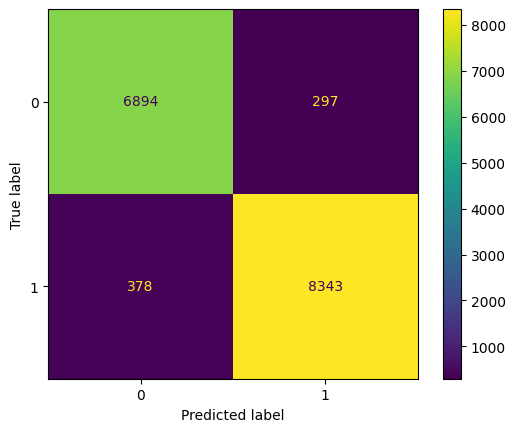

In [34]:
matrix=confusion_matrix(true,answer,labels=[0,1])
show=ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=[0,1])
show.plot()
plt.show()

In [ ]:
torch.save(model.state_dict(),"Text_Image_Classifier.pt")

In [ ]:
model_1=Text_Image_Classifier()

In [ ]:
model_1.load_state_dict(torch.load('Text_Image_Classifier.pt'))

<All keys matched successfully>